In [2]:
from matplotlib import pyplot
from pandas import read_csv, DataFrame, Series, isnull
from numpy import quantile, nan, concatenate, log

In [5]:
mdata = read_csv('counting-output/l2_counts.tsv', header=0, sep='\t')
mdata = mdata.T
mdata.columns = mdata.iloc[0].to_list()
mdata = mdata.iloc[1:]
region_list = mdata.columns.to_list()[:-1]
mdata.head(2)

,1_10002945_10003896,1_100315326_100316120,1_1003813_1004865,1_100435187_100436167,1_100503312_100504500,1_10057059_10058046,1_100598041_100598939,1_100714848_100715562,1_100731266_100732388,1_100817690_100819049,...,Y_21237773_21239809,Y_21728794_21730239,Y_21906086_21907084,Y_2709417_2710095,Y_2802900_2804561,Y_6777175_6777489,Y_6778279_6779833,Y_7140665_7141373,Y_7141558_7143307,ctrl_sum
C0018262,5,7,16,11,8,27,14,3,14,11,...,0,0,0,0,0,0,0,0,0,131897
C0018225,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,71197


In [6]:
clean_regions = []
for r in region_list:
    if "X" in r or "Y" in r:
        continue
    clean_regions.append(r)

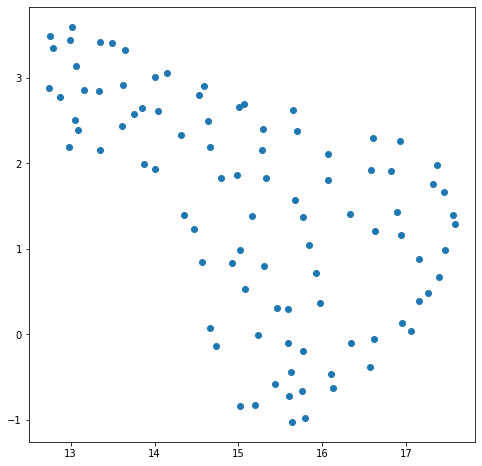

In [7]:
## projection of samplesfrom umap 
from umap import UMAP
reducer = UMAP()
embedding = reducer.fit_transform(mdata[clean_regions])

pyplot.rcParams['figure.figsize'] = [8, 8]
_ = pyplot.scatter(embedding[:,0], embedding[:,1])

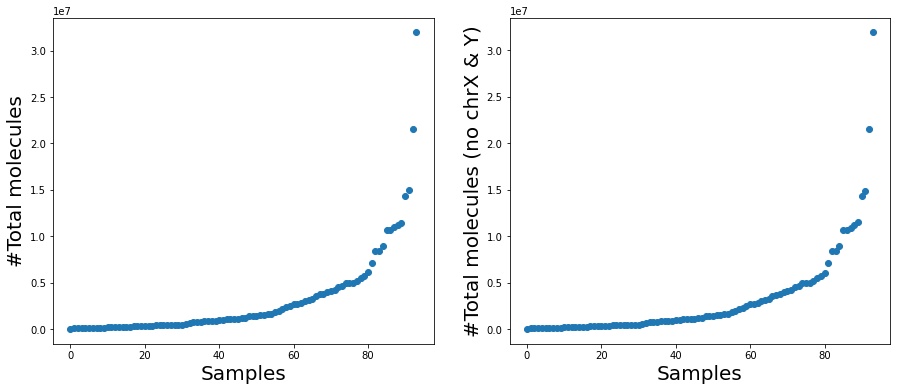

In [11]:
## on-target molecules per sample
pyplot.rcParams['figure.figsize'] = [15, 6]

_ = pyplot.subplot(1,2,1)
_ = pyplot.scatter(range(mdata.shape[0]), sorted(mdata.iloc[:, :-1].sum(axis=1)))
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Total molecules", fontsize=20)

_ = pyplot.subplot(1,2,2)
_ = pyplot.scatter(range(mdata.shape[0]), sorted(mdata[clean_regions].sum(axis=1)))
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Total molecules (no chrX & Y)", fontsize=20)

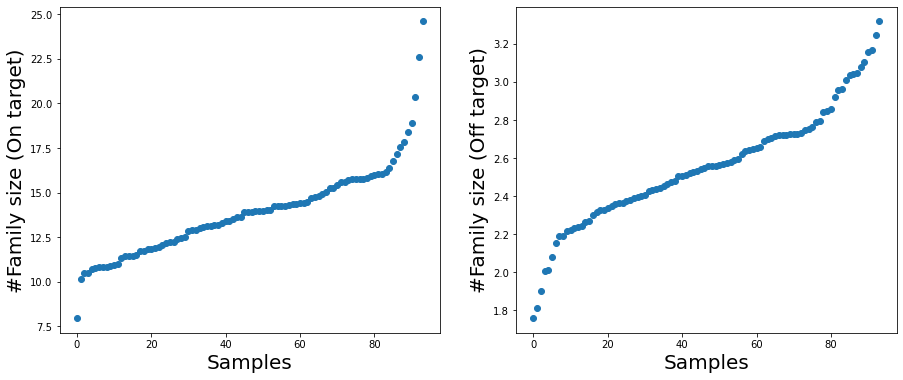

In [9]:
## family size
indata = read_csv('counting-output/om009-family-offtarget.csv', header=0, sep='\t')
indata.head(2)

pyplot.rcParams['figure.figsize'] = [15, 6]
_ = pyplot.subplot(1,2,1)
_ = pyplot.scatter(range(indata.shape[0]), sorted(indata["ontarget_fam_size"]))
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Family size (On target)", fontsize=20)

_ = pyplot.subplot(1,2,2)
_ = pyplot.scatter(range(indata.shape[0]), sorted(indata["offtarget_fam_size"]))
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Family size (Off target)", fontsize=20)

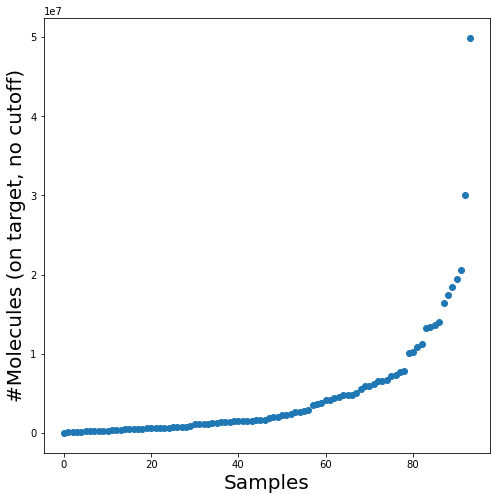

In [13]:
## on-target molecules: sanity check
pyplot.rcParams['figure.figsize'] = [8, 8]
_ = pyplot.scatter(range(indata.shape[0]), sorted(indata["ontarget_sum"]))
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Molecules (on target, no cutoff)", fontsize=20)

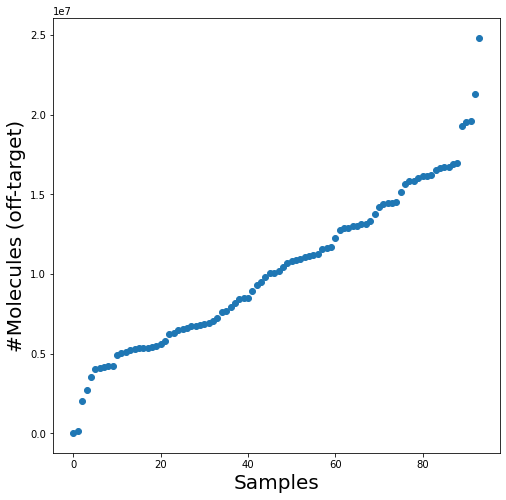

In [10]:
## off-target molecules
pyplot.rcParams['figure.figsize'] = [8, 8]
_ = pyplot.scatter(range(indata.shape[0]), sorted(indata["offtarget_sum"]))
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Molecules (off-target)", fontsize=20)